In [1]:
include("../src/GaussianFilters.jl")
using .GaussianFilters # . done before adding to package repo

using LinearAlgebra
using Distributions

### Dynamics Model

In [2]:
Δ = 1 # Sampling Period
σ_p = 5


F = [ Matrix{Float64}(I,2,2) Δ*Matrix{Float64}(I,2,2) ;
    zeros(Float64,2,2) Matrix{Float64}(I,2,2) ]

Q  = σ_p^2 * [ (Δ^4)/4*Matrix{Float64}(I,2,2) (Δ^3)/4*Matrix{Float64}(I,2,2) ;
            (Δ^3)/4*Matrix{Float64}(I,2,2) (Δ^2)*Matrix{Float64}(I,2,2) ]

Dyns = Dynamics(F,Q);

### Measurement Model

In [3]:
σ_m = 10

C = [ Matrix{Float64}(I,2,2) zeros(Float64,2,2) ]
R = σ_m^2 * Matrix{Float64}(I,2,2)

Meas = Measurement(C,R);

### Birth Model

Birthing refers to an object appearing in space based on some distribution of mixed gaussians

In [4]:
w1 = 0.1
w2 = 0.1
m_γ1 = [ 250 , 250 , 0 , 0]
m_γ2 = [ -250 , -250 , 0 , 0 ]
P_γ = Matrix(Diagonal([100 , 100 , 25 , 25]));

### Spawn Model
Spawning refers to a new target appearing from an already existing target

In [5]:
Q_β = Matrix(Diagonal([100.0 , 100.0 , 400.0 , 400.0]))

β = GaussianMixture([w1, w2] , [m_γ1, m_γ2] , [P_γ, P_γ])
spawn = Spawn(β , [Dyns,Dyns]);

### Clutter Model

In [6]:
# Creates a uniform distriubtion given a single measurement z [px,py]
function κ(z)
    V = 4*10^6 #Surveillance volume
    λ_c = 12.5*10^-6 #Average clutter returns per unit volume
    return λ_c*V*(1/(2000^2))
end;

### Miscellaneous Parameters

In [7]:
Ps = 0.99 # Probability of survival
Pd = 0.98 # Probability of detection

T = 10^-5 # Truncation threshold
U = 4 # Merging threshold
J_max = 10; # Max number of Gaussian terms

### Surveillance Example Instantiation

In [8]:
w_target1 = 1;
w_target2 = 1;
mu_target1 = [ -300.0 , -300.0 , 0.0 , 0.0 ]
mu_target2 = [ 300.0 , 300.0 , 0.0 , 0.0 ]
P_agent1 = Matrix(Diagonal([100.0 , 100.0 , 25.0 , 25.0]))
P_agent2 = P_agent1
γ = GaussianMixture([w_target1, w_target2] , [mu_target1, mu_target2] ,
                    [P_agent1, P_agent2]);

### Simulation
Propagate the truth. Include birth at $t = 40$ s

In [9]:
xsim = [γ.μ]
for t = 1 : Δ : 100
    MVD = MvNormal(Dyns.Q)
    x_new = [  Dyns.A*xsim[t][i] + rand(MVD,1)[:] for i=1:length(xsim[t]) ]
    if t == 66
        MVDspawn = MvNormal(Q_β)
        x1 = xsim[t][1]
        x_spawn = Dyns.A*x1 + rand(MVDspawn,1)[:]
        push!(x_new,x_spawn)
    end
    if t == 40
        x_birth = m_γ2
        push!(x_new,x_birth)
    end
    push!(xsim,x_new)
end

### PHD Filter
Instantiate the filter and run it on the simulation

In [10]:
# Instantiate the GM-PHD filter
phd = PHDFilter(γ,spawn,Dyns,Meas,Ps,Pd,κ)

# Initialize state of objects: x = γ
x =  [γ]

# Run PHD filter
for t = 1:Δ:100
    MVD = MvNormal(Meas.R)
    z = [ Meas.C*xsim[t][i] + rand(MVD,1)[:] for i=1:length(xsim[t])]
    x_new_pruned = step_prune(x[t],z,phd,T,U,J_max)
    push!(x, x_new_pruned)
end

### Plot Result

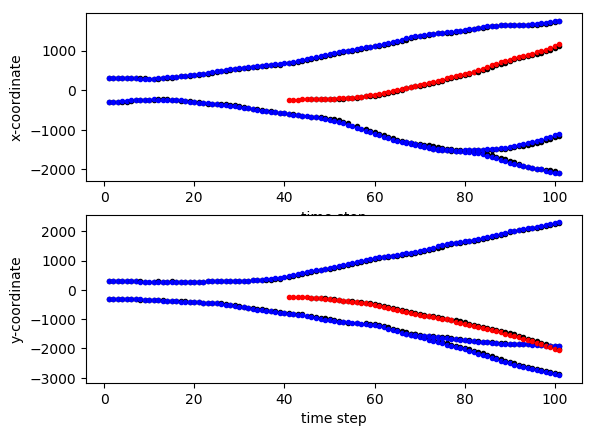

C:\Users\Saint Pablo\.julia\conda\3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\Saint Pablo\.julia\conda\3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


In [11]:
using PyPlot

for (t,x) in enumerate(x)
    mu_arr = multiple_target_state_extraction(x,0.5)
    for mu in mu_arr
        subplot(211)
        plot(t,mu[1],"k.")
        subplot(212)
        plot(t,mu[2],"k.")
    end
    subplot(211)
    plot(t,xsim[t][1][1],"b.")
    plot(t,xsim[t][2][1],"b.")
    if t > 66
        plot(t,xsim[t][4][1],"b.")
    end
    if t > 40
        plot(t,xsim[t][3][1],"r.")
    end
    subplot(212)
    plot(t,xsim[t][1][2],"b.")
    plot(t,xsim[t][2][2],"b.")
    if t > 66
        plot(t,xsim[t][4][2],"b.")
    end
    if t > 40
        plot(t,xsim[t][3][2],"r.")
    end
end
subplot(211)
xlabel("time step")
ylabel("x-coordinate")
subplot(212)
xlabel("time step")
ylabel("y-coordinate")
show()